# Randomly select n files and save to another destination and rename it 

In [11]:
import shutil, random, os
dirpath = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\1_dataRename\non-defects'
destDirectory = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\2_selected for ML'
n_files = 2000

filenames = random.sample(os.listdir(dirpath), n_files)

for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.copy(srcpath, destDirectory)

In [12]:
# 等上面完成再执行不然会互相占用
for i, filename in enumerate(os.listdir(destDirectory)):
    os.rename(destDirectory + "/" + filename, destDirectory + "/" + "0_nondefects_" + str(i) + ".jpg")

# Rename files

In [4]:
import shutil, random, os
os.getcwd()
collection = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\1_dataRename\crack"
for i, filename in enumerate(os.listdir(collection)):
    os.rename(collection + "/" + filename, collection + "/" + "2_crack_" + str(i) + ".jpg")
    
# 手动复制到2_selected for ML

In [4]:
import shutil, random, os
os.getcwd()
collection = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\1_dataRename\g"
for i, filename in enumerate(os.listdir(collection)):
    os.rename(collection + "/" + filename, collection + "/" + "1_mould_" + str(i) + ".jpg")
    
# 手动复制到2_selected for ML

# Make sure all the images are 3 channel "rgb" before the augmentation

In [14]:
import os
from PIL import Image

os.getcwd()
img_dir = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\2_selected for ML"
for i, filename in enumerate([f for f in os.listdir(img_dir) if not f.startswith('.')]):#get rid of ds.sore
    img = Image.open(img_dir+ "/"+filename).convert('RGB')
    img.save(img_dir + "/" + filename)

# Transform and augment the custom data and save it to merged folder

In [15]:
# data load and augmentation
# https://www.youtube.com/watch?v=Zvd276j9sZ8
# https://www.youtube.com/watch?v=rAdLwKJBvPM&t=586s

from torchvision.utils import save_image
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
torch.manual_seed(42)


img_dir = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\1_dataRename\g"
transformed_folder = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\3_augted&Normalised'

# 0_non: 2000
# 1_bigrowth:657 * 3 = 1971
# 2_crack: 1955
# 5926 in total
aug_iter = 2 #图片要经过几次aug，也就是生成的新的图片数，1就是全部aug一遍，2就是全部aug两遍


# my_transforms = transforms.Compose(
#     [  # Compose makes it possible to have many transforms
        
#         transforms.Resize((224, 224)),  # Resizes
#         transforms.ColorJitter(brightness=0.3),  # Change brightness of image
#         transforms.RandomAutocontrast(p=0.2),
#         transforms.RandomEqualize(),
#         transforms.RandomRotation(
#             degrees=45
#         ),  # Perhaps a random rotation from -45 to 45 degrees
#         transforms.RandomHorizontalFlip(
#             p=0.5
#         ),  # Flips the image horizontally with probability 0.5
#         transforms.RandomVerticalFlip(
#             p=0.05
#         ),  # Flips image vertically with probability 0.05
# #         transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
#         transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] #https://pytorch.org/vision/stable/models.html
#         ),
#     ]
# )


# use auto aug suited for imagenet trained model
policy = transforms.AutoAugmentPolicy.IMAGENET
my_transforms = transforms.Compose([
                                     transforms.AutoAugment(policy),
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                    
                                    ])

for i in range(aug_iter):
    for _, filename in enumerate([f for f in os.listdir(img_dir) if not f.startswith('.')]): 
        img = Image.open(img_dir+"/"+filename)
        img_aug = my_transforms(img)
        save_image(img_aug, transformed_folder + "/" + filename[:-4] + "+" + str(i) + '.jpg')


# The original dataset should be sized and normalised as well and save to merged folder

In [16]:
from torchvision.utils import save_image
import os
from PIL import Image

original_folder = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\2_selected for ML'
transformed_folder = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\3_augted&Normalised'


my_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        
        transforms.Resize((224, 224)),  # Resizes
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225] #https://pytorch.org/vision/stable/models.html
        ),
    ]
)

for _, filename in enumerate([f for f in os.listdir(original_folder) if not f.startswith('.')]):
    img = Image.open(original_folder+"/"+filename)
    img = my_transforms(img)
    save_image(img, transformed_folder + "/" + filename)

# Transfer learning

In [18]:
# https://www.youtube.com/watch?v=qaDe0qQZ5AQ
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt
torch.manual_seed(42)#You can use torch.manual_seed function to seed the script globally
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from skimage import io
import os
from torch.utils.data import Dataset

In [117]:
'''Hyperparameters'''
num_classes = 3
learning_rate = 1e-4
batch_size = 100
num_epochs = 200
test_size = 0.25

# two writers for different colour
# 如果重新写入数据的话，就要关闭tensorboard然后重新运行下列writter代码
writer = SummaryWriter('runs/2_layer4&fc')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# real data path
path_merged = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\3_augted&Normalised'
# # less image for quick train test
# path_merged = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\4_smallDataset'

In [118]:

# Designed for equal portion split  
class WallDefects(Dataset): #inherit from Dataset
    def __init__(self, root_dir, data, label, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index])
        image = io.imread(img_path)
        y_label = torch.tensor(self.label[index])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    
    
# or you want equal portion for each classes
# using tensorflow train_test_split, stratify=y for equal portion split based on label
# https://discuss.pytorch.org/t/how-to-split-test-and-train-data-keeping-equal-proportions-of-each-class/21063/5
X = np.array([f for f in os.listdir(path_merged) if not f.startswith('.')])
y = np.array([filename[0] for filename in X]).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)

train_set = WallDefects(path_merged, data=X_train, label=y_train, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_set = WallDefects(path_merged, data=X_test, label=y_test,transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [119]:
len(X),len(X_train),len(X_test)

(5926, 4444, 1482)

target label: 1


(<matplotlib.image.AxesImage at 0x209543aebb0>, None)

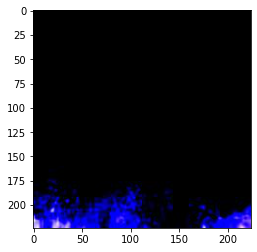

In [120]:
# 0_non: 2000
# 1_bigrowth:657 * 3 = 1971
# 2_crack: 1955
# total images = 2000+1971+1955=5926

def showImage(index, dataset):
    return plt.imshow(dataset[index][0].permute(1, 2, 0)),print(f'target label: {dataset[index][1]}')
showImage(-1, train_set) 

In [121]:

'''Load pretrained model'''
# Load pretrain model 
model = torchvision.models.resnet50(pretrained=True)
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in model.parameters():
    param.requires_grad = False

# set last layer trainable for to evalate the localisation capability since fc does not do localisation
# you could also be more specific, like layer4[0], here we train the entire layer4
for param in model.layer4.parameters():
    param.requires_grad = True

'''Modify the fully connected layer of the model'''
# modify the last fully connected layer to simple layer, because we wanna train lasy conv layer 
# which should be trained to do classificaiton and localisation both well
model.fc = nn.Sequential(
    nn.Linear(2048, num_classes)
)


# # how about freeze the fc as well, try if layer4 can do better localsation, since all classificaiton and
# # localisation work is done by layer 4
# for param in model.fc.parameters():
#     param.requires_grad = False



model.to(device)
print(model)


# complicate fc in the first experiment
# model.fc = nn.Sequential(
#     nn.Linear(2048, 1000), nn.ReLU(), 
#     nn.Linear(1000, 500), nn.ReLU(), 
#     nn.Linear(500, 200), nn.ReLU(), 
#     nn.Linear(200, num_classes)
# )

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [122]:
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# check which layer requires grad
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
        
        
# how about fixing FC layers? 
# so all the learning happens in the last convlayer, is it even better for localisation?

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.0.weight
fc.0.bias


In [123]:
'''Training and check the cost'''
# difference btw ce and bce, here we use ce as later data size all based on it
# https://discuss.pytorch.org/t/can-i-use-cross-entropy-loss-as-a-binary-loss/39314/2
# Loss
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() #binary cross entrpy


# pytorch optimizer explicitly accepts parameter that requires grad
# We haven’t done yet as even the required grad is set to False, we still can update the weights
# So we should filter the parameters to only those requires_grad ones by using this code
# https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)



lowest_loss = 9999
# Train Network
for epoch in range(num_epochs):
    
    '''training loss and accuracy cals'''
    losses = []
    num_correct = 0
    num_samples = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.type(torch.LongTensor)
        targets = targets.to(device=device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()
        # for accuracy cals
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)


    # tensorboard
    # 因为存储的文件有很多不规则名字（例如_）所以直接用 tensorboard --logdir=runs 是找不到的，所以
    # 需要用他之前规则的路径，然后tensorboard会在这个大路径里面搜寻文件，例如下面这个就是规则大路径
    # runs文件和这个python文件在一起，但是不能用这个路径因为有不规则符号
    # terminal: tensorboard --logdir /Users/t.wang/Desktop/NUS/References
    writer.add_scalar("Loss/ ->Train", sum(losses)/len(losses), epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {sum(losses)/len(losses):.5f} -> Training cost")
    
    # tensorboard
    # terminal: tensorboard --logdir=runs
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Training", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Training accuracy"
    )
    
    
    
    '''test loss and accuracy cals'''
    model.eval() #no model tuning, just for test checking
    losses = []
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device=device)
            # forward
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss)
            # for accuracy cals
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    # Loss
    current_loss = sum(losses)/len(losses)
    writer.add_scalar("Loss/ ->Test", current_loss, epoch)
    print(f"Epoch {epoch+1} / {num_epochs} is {current_loss:.5f} -> Testing cost") 
    
    # Accuracy
    accuracy = round(float(num_correct)/float(num_samples)*100,2)
    writer.add_scalar(f"Accuracy/ ->Testing", accuracy, epoch)    
    print(
        f"Got {num_correct} correct / {num_samples} in total with accuracy {accuracy}% -> Testing accuracy"
    )

    
    # store the best model in terms of the loss
    if current_loss < lowest_loss:
        num = epoch+1
        best_model = model
        lowest_loss = current_loss
        highest_acc = accuracy
    print(f'the current best model is from epoch {num}')  
    print("==============================================================================")
    # Call flush() method to make sure that all pending events have been written to disk.  
    writer.flush()
    model.train() # back to model tuning again
    
    
# save the best model
print(f'saving the best model at {num}th epoch...')
torch.save(best_model.state_dict(), f'{num}th epoch_layer4&fc_Testingloss={lowest_loss:.5f} and acc={highest_acc}%.pth')        
print('Job Done!!!!!')

# 大概5h算10epoch，半小时1个epoch

Epoch 1 / 200 is 1.02453 -> Training cost
Got 2204 correct / 4444 in total with accuracy 49.59% -> Training accuracy
Epoch 1 / 200 is 0.91224 -> Testing cost
Got 958 correct / 1482 in total with accuracy 64.64% -> Testing accuracy
the current best model is from epoch 1
Epoch 2 / 200 is 0.81886 -> Training cost
Got 3342 correct / 4444 in total with accuracy 75.2% -> Training accuracy
Epoch 2 / 200 is 0.74752 -> Testing cost
Got 1129 correct / 1482 in total with accuracy 76.18% -> Testing accuracy
the current best model is from epoch 2
Epoch 3 / 200 is 0.68084 -> Training cost
Got 3682 correct / 4444 in total with accuracy 82.85% -> Training accuracy
Epoch 3 / 200 is 0.62953 -> Testing cost
Got 1225 correct / 1482 in total with accuracy 82.66% -> Testing accuracy
the current best model is from epoch 3
Epoch 4 / 200 is 0.58023 -> Training cost
Got 3825 correct / 4444 in total with accuracy 86.07% -> Training accuracy
Epoch 4 / 200 is 0.55045 -> Testing cost
Got 1253 correct / 1482 in tota

Epoch 24 / 200 is 0.23215 -> Testing cost
Got 1352 correct / 1482 in total with accuracy 91.23% -> Testing accuracy
the current best model is from epoch 24
Epoch 25 / 200 is 0.19741 -> Training cost
Got 4157 correct / 4444 in total with accuracy 93.54% -> Training accuracy
Epoch 25 / 200 is 0.22562 -> Testing cost
Got 1356 correct / 1482 in total with accuracy 91.5% -> Testing accuracy
the current best model is from epoch 25
Epoch 26 / 200 is 0.19113 -> Training cost
Got 4170 correct / 4444 in total with accuracy 93.83% -> Training accuracy
Epoch 26 / 200 is 0.22076 -> Testing cost
Got 1355 correct / 1482 in total with accuracy 91.43% -> Testing accuracy
the current best model is from epoch 26
Epoch 27 / 200 is 0.18385 -> Training cost
Got 4182 correct / 4444 in total with accuracy 94.1% -> Training accuracy
Epoch 27 / 200 is 0.21907 -> Testing cost
Got 1355 correct / 1482 in total with accuracy 91.43% -> Testing accuracy
the current best model is from epoch 27
Epoch 28 / 200 is 0.1827

Epoch 48 / 200 is 0.12543 -> Training cost
Got 4273 correct / 4444 in total with accuracy 96.15% -> Training accuracy
Epoch 48 / 200 is 0.17808 -> Testing cost
Got 1374 correct / 1482 in total with accuracy 92.71% -> Testing accuracy
the current best model is from epoch 48
Epoch 49 / 200 is 0.12146 -> Training cost
Got 4277 correct / 4444 in total with accuracy 96.24% -> Training accuracy
Epoch 49 / 200 is 0.17494 -> Testing cost
Got 1370 correct / 1482 in total with accuracy 92.44% -> Testing accuracy
the current best model is from epoch 49
Epoch 50 / 200 is 0.11768 -> Training cost
Got 4296 correct / 4444 in total with accuracy 96.67% -> Training accuracy
Epoch 50 / 200 is 0.17160 -> Testing cost
Got 1376 correct / 1482 in total with accuracy 92.85% -> Testing accuracy
the current best model is from epoch 50
Epoch 51 / 200 is 0.11556 -> Training cost
Got 4298 correct / 4444 in total with accuracy 96.71% -> Training accuracy
Epoch 51 / 200 is 0.17552 -> Testing cost
Got 1376 correct /

Epoch 71 / 200 is 0.15761 -> Testing cost
Got 1391 correct / 1482 in total with accuracy 93.86% -> Testing accuracy
the current best model is from epoch 71
Epoch 72 / 200 is 0.07828 -> Training cost
Got 4362 correct / 4444 in total with accuracy 98.15% -> Training accuracy
Epoch 72 / 200 is 0.15777 -> Testing cost
Got 1383 correct / 1482 in total with accuracy 93.32% -> Testing accuracy
the current best model is from epoch 71
Epoch 73 / 200 is 0.07742 -> Training cost
Got 4357 correct / 4444 in total with accuracy 98.04% -> Training accuracy
Epoch 73 / 200 is 0.15841 -> Testing cost
Got 1387 correct / 1482 in total with accuracy 93.59% -> Testing accuracy
the current best model is from epoch 71
Epoch 74 / 200 is 0.07789 -> Training cost
Got 4350 correct / 4444 in total with accuracy 97.88% -> Training accuracy
Epoch 74 / 200 is 0.15424 -> Testing cost
Got 1388 correct / 1482 in total with accuracy 93.66% -> Testing accuracy
the current best model is from epoch 74
Epoch 75 / 200 is 0.07

Epoch 95 / 200 is 0.05619 -> Training cost
Got 4391 correct / 4444 in total with accuracy 98.81% -> Training accuracy
Epoch 95 / 200 is 0.15030 -> Testing cost
Got 1398 correct / 1482 in total with accuracy 94.33% -> Testing accuracy
the current best model is from epoch 93
Epoch 96 / 200 is 0.05712 -> Training cost
Got 4392 correct / 4444 in total with accuracy 98.83% -> Training accuracy
Epoch 96 / 200 is 0.15186 -> Testing cost
Got 1392 correct / 1482 in total with accuracy 93.93% -> Testing accuracy
the current best model is from epoch 93
Epoch 97 / 200 is 0.05207 -> Training cost
Got 4398 correct / 4444 in total with accuracy 98.96% -> Training accuracy
Epoch 97 / 200 is 0.15244 -> Testing cost
Got 1395 correct / 1482 in total with accuracy 94.13% -> Testing accuracy
the current best model is from epoch 93
Epoch 98 / 200 is 0.05539 -> Training cost
Got 4388 correct / 4444 in total with accuracy 98.74% -> Training accuracy
Epoch 98 / 200 is 0.14867 -> Testing cost
Got 1394 correct /

Epoch 118 / 200 is 0.14831 -> Testing cost
Got 1393 correct / 1482 in total with accuracy 93.99% -> Testing accuracy
the current best model is from epoch 116
Epoch 119 / 200 is 0.04180 -> Training cost
Got 4410 correct / 4444 in total with accuracy 99.23% -> Training accuracy
Epoch 119 / 200 is 0.14981 -> Testing cost
Got 1397 correct / 1482 in total with accuracy 94.26% -> Testing accuracy
the current best model is from epoch 116
Epoch 120 / 200 is 0.04085 -> Training cost
Got 4415 correct / 4444 in total with accuracy 99.35% -> Training accuracy
Epoch 120 / 200 is 0.14602 -> Testing cost
Got 1397 correct / 1482 in total with accuracy 94.26% -> Testing accuracy
the current best model is from epoch 120
Epoch 121 / 200 is 0.04153 -> Training cost
Got 4408 correct / 4444 in total with accuracy 99.19% -> Training accuracy
Epoch 121 / 200 is 0.14837 -> Testing cost
Got 1394 correct / 1482 in total with accuracy 94.06% -> Testing accuracy
the current best model is from epoch 120
Epoch 122 /

Epoch 142 / 200 is 0.03243 -> Training cost
Got 4415 correct / 4444 in total with accuracy 99.35% -> Training accuracy
Epoch 142 / 200 is 0.14788 -> Testing cost
Got 1398 correct / 1482 in total with accuracy 94.33% -> Testing accuracy
the current best model is from epoch 135
Epoch 143 / 200 is 0.03628 -> Training cost
Got 4415 correct / 4444 in total with accuracy 99.35% -> Training accuracy
Epoch 143 / 200 is 0.14614 -> Testing cost
Got 1400 correct / 1482 in total with accuracy 94.47% -> Testing accuracy
the current best model is from epoch 135
Epoch 144 / 200 is 0.02975 -> Training cost
Got 4421 correct / 4444 in total with accuracy 99.48% -> Training accuracy
Epoch 144 / 200 is 0.15056 -> Testing cost
Got 1402 correct / 1482 in total with accuracy 94.6% -> Testing accuracy
the current best model is from epoch 135
Epoch 145 / 200 is 0.03170 -> Training cost
Got 4420 correct / 4444 in total with accuracy 99.46% -> Training accuracy
Epoch 145 / 200 is 0.14971 -> Testing cost
Got 1400

Epoch 165 / 200 is 0.15225 -> Testing cost
Got 1400 correct / 1482 in total with accuracy 94.47% -> Testing accuracy
the current best model is from epoch 163
Epoch 166 / 200 is 0.02871 -> Training cost
Got 4421 correct / 4444 in total with accuracy 99.48% -> Training accuracy
Epoch 166 / 200 is 0.15005 -> Testing cost
Got 1401 correct / 1482 in total with accuracy 94.53% -> Testing accuracy
the current best model is from epoch 163
Epoch 167 / 200 is 0.02897 -> Training cost
Got 4416 correct / 4444 in total with accuracy 99.37% -> Training accuracy
Epoch 167 / 200 is 0.14912 -> Testing cost
Got 1403 correct / 1482 in total with accuracy 94.67% -> Testing accuracy
the current best model is from epoch 163
Epoch 168 / 200 is 0.02933 -> Training cost
Got 4421 correct / 4444 in total with accuracy 99.48% -> Training accuracy
Epoch 168 / 200 is 0.14436 -> Testing cost
Got 1401 correct / 1482 in total with accuracy 94.53% -> Testing accuracy
the current best model is from epoch 163
Epoch 169 /

Epoch 189 / 200 is 0.02323 -> Training cost
Got 4423 correct / 4444 in total with accuracy 99.53% -> Training accuracy
Epoch 189 / 200 is 0.15240 -> Testing cost
Got 1402 correct / 1482 in total with accuracy 94.6% -> Testing accuracy
the current best model is from epoch 163
Epoch 190 / 200 is 0.02687 -> Training cost
Got 4417 correct / 4444 in total with accuracy 99.39% -> Training accuracy
Epoch 190 / 200 is 0.14872 -> Testing cost
Got 1402 correct / 1482 in total with accuracy 94.6% -> Testing accuracy
the current best model is from epoch 163
Epoch 191 / 200 is 0.02416 -> Training cost
Got 4423 correct / 4444 in total with accuracy 99.53% -> Training accuracy
Epoch 191 / 200 is 0.14860 -> Testing cost
Got 1402 correct / 1482 in total with accuracy 94.6% -> Testing accuracy
the current best model is from epoch 163
Epoch 192 / 200 is 0.02523 -> Training cost
Got 4425 correct / 4444 in total with accuracy 99.57% -> Training accuracy
Epoch 192 / 200 is 0.15152 -> Testing cost
Got 1403 c